# Project Overview

This notebook details different rock paper scissors bots and compares them in a tournament.

* Dumb bots
* Mirror
* Counter Mirror
* Switch
* Nash Equilibrium
* Statistical Bot
* Markov Chain
* Opponent Transition Matrix
* Many Armed Bandit
* Decision Tree
* Iocaine
* Memory Pattern Recogniser

This notebook is a copy of my kaggle notebook which has a solution currently ranked ~50th


In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import random

# Our First Bots:

In [2]:
%%writefile rock.py
def rock(observation, configuration):
    return 0

Overwriting rock.py


In [3]:
%%writefile paper.py

def paper(observation, configuration):
    return 1

Overwriting paper.py


In [4]:
%%writefile scissors.py

def scissors(observation, configuration):
    return 2

Overwriting scissors.py


# Mirroring our Opponent

In [5]:
%%writefile mirror.py

def copy_opponent (observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return 1 # start with scissors

Overwriting mirror.py


# Reacting with Lag

In [6]:
%%writefile switched.py

def react (observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 1

Overwriting switched.py


In [7]:
%%writefile counter_mirror.py

def counter_mirror (observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % 3
    else:
        return 1

Overwriting counter_mirror.py


# Nash Equilibrium (random)

In [17]:
%%writefile nash_equilibrium.py
import random

def nash_equilibrium(observation, configuration):
    return random.randint(0, 2)

Overwriting nash_equilibrium.py


# A Statistical Solution

In [9]:
%%writefile statistical.py

from kaggle_environments.envs.rps.utils import get_score

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    
    if observation.step == 0:
        action_histogram = {}
        return
    
    action = observation.lastOpponentAction
    
    if action not in action_histogram:
        action_histogram[action] = 0
        
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


# Markov Agent

In [27]:
%%writefile markov_agent.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
        
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    
    return int(action)

Writing markov_agent.py


# Opponent Transition Matrix

from https://www.kaggle.com/group16/rps-opponent-transition-matrix

In [35]:
%%writefile opp_transition_matrix.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# prev is the action of the opponent 1 step ago
# prev2 is the action of the opponent 2 steps ago
prev, prev2 = None, None

def transition_agent(observation, configuration):
    global T, P, prev, prev2
    
    if observation.step > 1:
        prev = observation.lastOpponentAction
        T[prev2, prev] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        prev2 = prev
        if np.sum(P[prev, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[prev, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            prev2 = observation.lastOpponentAction
            
        return int(np.random.randint(3))

Writing opp_transition_matrix.py


# Observe and Adapt Transition Matrix

plays randomly for first 100 matches

from https://www.kaggle.com/ttahara/rps-observe-and-predict-baseline

In [3]:
%%writefile obs_adapt.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3, 3))

self_actions = np.full(1001, -1, dtype=int)
oppo_actions = np.full(1001, -1, dtype=int)

observe_until = 600

def observe_and_predict(observation, configuration):
    
    step = observation.step
    global T, P
    global self_actions, oppo_actions
    global observe_until
    
    if step == 0:
        self_act = np.random.randint(3)
        self_actions[step] = self_act
        return self_act
    
    self_1s_bef = self_actions[step - 1]
    oppo_1s_bef = observation.lastOpponentAction
    oppo_actions[step - 1] = oppo_1s_bef
    
    if 2 <= step < observe_until:
        self_2s_bef = self_actions[step - 2]
        oppo_2s_bef = oppo_actions[step - 2]
        T[self_2s_bef][oppo_2s_bef][oppo_1s_bef] += 1

    P = T / np.maximum(1, T.sum(axis=2)[..., None])    
    p = P[self_1s_bef][oppo_1s_bef]
    
    if observe_until <= step and np.sum(p) == 1:
        self_act = int((np.random.choice([0, 1, 2], p=p) + 1)) % 3
    else:
        self_act = np.random.randint(3)
    
    self_actions[step] = self_act
    return self_act

Overwriting obs_adapt.py


# Many Armed Bandit

taken from: https://www.kaggle.com/ilialar/multi-armed-bandit-vs-deterministic-agents

The multi-armed bandit approach is a Reinforcement learning technic that allows us to select the most promising counter-strategy and use it to beat the opponent.

Algorithm logic:

* Create N agents with different logic
* At each step for each agent, generate a random number from B(a+1, b+1). B - beta-distribution, a - number of historical wins of this agent, b - number of this agent's historical losses.
* Select the agent with the largest generated number and use it to generate the next step.
* Repeat

In this notebook, I also show how to create the following types of agents:

Mirror + shift. This class of agents takes the opponent's last step and return (step + shift) % 3. E.g., with shift=0 - it is a mirroring agent, with shift=1 agent that beats the opponent's previous hand.

Self + shift. These agents add some shifts to their previous steps. With shift=0, it is a constant agent. With shift = 1 or 2, it just repeats all 3 possible steps in direct or reversed order.

Popular beater - returns the step that beats the most popular action of the opponent so far.

Anti-popular beater - return the step that beats the step that wins the most popular step )

Transition matrix - computes the historical probability to go from one state to another (both for opponent and yourself) and returns the step that beats the most probable step of the opponent.

Transition tensor - the same thing but considers both player's and opponent's previous steps. The last two agents have both deterministic and random versions and a decay option - higher weight for the more recent rounds.

Pattern matching - is a development of the transition matrix idea that takes into account n last steps. It is inspired by https://www.kaggle.com/yegorbiryukov/rock-paper-scissors-with-memory-patterns.

In [34]:
%%writefile multi_armed_bandit.py

import pandas as pd
import numpy as np
import json


# base class for all agents, random agent
class agent():
    def initial_step(self):
        return np.random.randint(3)
    
    def history_step(self, history):
        return np.random.randint(3)
    
    def step(self, history):
        if len(history) == 0:
            return int(self.initial_step())
        else:
            return int(self.history_step(history))
    
# agent that returns (previousCompetitorStep + shift) % 3
class mirror_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['competitorStep'] + self.shift) % 3
    
    
# agent that returns (previousPlayerStep + shift) % 3
class self_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['step'] + self.shift) % 3    


# agent that beats the most popular step of competitor
class popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['competitorStep'] for x in history])
        return (int(np.argmax(counts)) + 1) % 3

    
# agent that beats the agent that beats the most popular step of competitor
class anti_popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['step'] for x in history])
        return (int(np.argmax(counts)) + 2) % 3
    
    
# simple transition matrix: previous step -> next step
class transition_matrix(agent):
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type = 'step' 
        else:
            self.step_type = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3)) + self.init_value
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type]), int(history[i+1][self.step_type])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type])]/matrix[int(history[-1][self.step_type])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3
    

# similar to the transition matrix but rely on both previous steps
class transition_tensor(agent):
    
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type1 = 'step' 
            self.step_type2 = 'competitorStep'
        else:
            self.step_type2 = 'step' 
            self.step_type1 = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3, 3)) + 0.1
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type1]), int(history[i][self.step_type2]), int(history[i+1][self.step_type1])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])]/matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3

    
agents = {
    'mirror_0': mirror_shift(0),
    'mirror_1': mirror_shift(1),  
    'mirror_2': mirror_shift(2),
    'self_0': self_shift(0),
    'self_1': self_shift(1),  
    'self_2': self_shift(2),
    'popular_beater': popular_beater(),
    'anti_popular_beater': anti_popular_beater(),
    'random_transitison_matrix': transition_matrix(False, False),
    'determenistic_transitison_matrix': transition_matrix(True, False),
    'random_self_trans_matrix': transition_matrix(False, True),
    'determenistic_self_trans_matrix': transition_matrix(True, True),
    'random_transitison_tensor': transition_tensor(False, False),
    'determenistic_transitison_tensor': transition_tensor(True, False),
    'random_self_trans_tensor': transition_tensor(False, True),
    'determenistic_self_trans_tensor': transition_tensor(True, True),
    
    'random_transitison_matrix_decay': transition_matrix(False, False, decay = 1.05),
    'random_self_trans_matrix_decay': transition_matrix(False, True, decay = 1.05),
    'random_transitison_tensor_decay': transition_tensor(False, False, decay = 1.05),
    'random_self_trans_tensor_decay': transition_tensor(False, True, decay = 1.05),
    
    'determenistic_transitison_matrix_decay': transition_matrix(True, False, decay = 1.05),
    'determenistic_self_trans_matrix_decay': transition_matrix(True, True, decay = 1.05),
    'determenistic_transitison_tensor_decay': transition_tensor(True, False, decay = 1.05),
    'determenistic_self_trans_tensor_decay': transition_tensor(True, True, decay = 1.05),
}

    
def multi_armed_bandit_agent (observation, configuration):
    
    # bandits' params
    step_size = 2 # how much we increase a and b 
    decay_rate = 1.05 # how much do we decay old historical data
    
    # I don't see how to use any global variables, so will save everything to a CSV file
    # Using pandas for this is too much, but it can be useful later and it is convinient to analyze
    def save_history(history, file = 'history.csv'):
        pd.DataFrame(history).to_csv(file, index = False)

    def load_history(file = 'history.csv'):
        return pd.read_csv(file).to_dict('records')
    
    
    def log_step(step = None, history = None, agent = None, competitorStep = None):
        if step is None:
            step = np.random.randint(3)
        if history is None:
            history = []
        history.append({'step': step, 'competitorStep': competitorStep, 'agent': agent})
        save_history(history)
        return step
    
    def update_competitor_step(history, competitorStep):
        history[-1]['competitorStep'] = int(competitorStep)
        return history
        
    
    # load history
    if observation.step == 0:
        history = []
        bandit_state = {k:[1,1] for k in agents.keys()}
    else:
        history = update_competitor_step(load_history(), observation.lastOpponentAction)
        
        # load the state of the bandit
        with open('bandit.json') as json_file:
            bandit_state = json.load(json_file)
        
        # updating bandit_state using the result of the previous step
        # we can update all states even those that were not used
        for name, agent in agents.items():
            agent_step = agent.step(history[:-1])
            bandit_state[name][1] = (bandit_state[name][1] - 1) / decay_rate + 1
            bandit_state[name][0] = (bandit_state[name][0] - 1) / decay_rate + 1
            
            if (history[-1]['competitorStep'] - agent_step) % 3 == 1:
                bandit_state[name][1] += step_size
            elif (history[-1]['competitorStep'] - agent_step) % 3 == 2:
                bandit_state[name][0] += step_size
            else:
                bandit_state[name][0] += step_size/2
                bandit_state[name][1] += step_size/2
            
    with open('bandit.json', 'w') as outfile:
        json.dump(bandit_state, outfile)
    
    
    # generate random number from Beta distribution for each agent and select the most lucky one
    best_proba = -1
    best_agent = None
    for k in bandit_state.keys():
        proba = np.random.beta(bandit_state[k][0],bandit_state[k][1])
        if proba > best_proba:
            best_proba = proba
            best_agent = k
        
    step = agents[best_agent].step(history)
    
    return log_step(step, history, best_agent)

Writing multi_armed_bandit.py


# Iocaine Powder (second and tripple guessing yourself)
The below code was taken from: http://davidbau.com/downloads/rps/rps-iocaine.py

Iocaine Powder is a heuristically designed compilation of strategies and
 meta-strategies, entered in Darse Billings' excellent First International
 RoShamBo Programming Competition.
 
  **Meta-Strategy**
 
 RoShamBo strategies attempt to predict what the opponent will do. Given a
 successful prediction, it is easy to defeat the opponent (if you know they
 will play rock, you play paper). However, straightforward prediction will
 often fail; the opponent may not be vulnerable to prediction, or worse, they
 might have anticipated your predictive logic and played accordingly. Iocaine
 Powder's meta-strategy expands any predictive algorithm P into six possible
 strategies:
 
 P.0: naive application:
 
      Assume the opponent is vulnerable to prediction by P; predict their
      next move, and play to beat it. If P predicts your opponent will play
      rock, play paper to cover rock. This is the obvious application of P.
 
 P.1: defeat second-guessing:
 
      Assume the opponent thinks you will use P.0. If P predicts rock, P.0
      would play paper to cover rock, but the opponent could anticipate this
      move and play scissors to cut paper. Instead, you play rock to dull
      scissors.
 
 P.2: defeat triple-guessing:
 
      Assume the opponent thinks you will use P.1. Your opponent thinks you
      will play rock to dull the scissors they would have played to cut the
      paper you would have played to cover the rock P would have predicted,
      so they will play paper to cover your rock. But you one-up them,
      playing scissors to cut their paper.
 
      At this point, you should be getting weary of the endless chain. "We
      could second-guess each other forever," you say. But no; because of the
      nature of RoShamBo, P.3 recommends you play paper -- just like P.0! So
      we're only left with these three strategies, each of which will suggest
      a different alternative. (This may not seem useful to you, but have
      patience.)
 
 P'.0: second-guess the opponent:
 
      This strategy assumes the opponent uses P themselves against you.
      Modify P (if necessary) to exchange the position of you and your
      opponent. If P' predicts that you will play rock, you would expect
      your opponent to play paper, but instead you play scissors.
 
 P'.1, P'.2: variations on a theme:
 
      As with P.1 and P.2, these represent "rotations" of the basic idea,
      designed to counteract your opponent's second-guessing.
 
 So, for even a single predictive algorithm P, we now have six possible
 strategies. One of them may be correct -- but that's little more useful
 than saying "one of rock, scissors, or paper will be the correct next
 move". We need a meta-strategy to decide between these six strategies.
 
 Iocaine Powder's basic meta-strategy is simple: Use past performance to
 judge future results.
 
 The basic assumption made by this meta-strategy is that an opponent will not
 quickly vary their strategy. Either they will play some predictive algorithm
 P, or they will play to defeat it, or use some level of second-guessing; but
 whatever they do, they will do it consistently. To take advantage of this
 (assumed) predictability, at every round Iocaine Powder measures how well
 each of the strategies under consideration (six for every predictive
 algorithm!)  would have done, if it had played them. It assigns each one a
 score, using the standard scoring scheme used by the tournament: +1 point if
 the strategy would have won the hand, -1 if it would have lost, 0 if it
 would have drawn.
 
 Then, to actually choose a move, Iocaine Powder simply picks the strategy
 variant with the highest score to date.
 
 The end result is that, for any given predictive technique, we will beat any
 contestant that would be beaten by the technique, any contestant using the
 technique directly, and any contestant designed to defeat the technique
 directly.
 
  **Strategies**
 
 All the meta-strategy in the world isn't useful without some predictive
 algorithms. Iocaine Powder uses three predictors:
 
 Random guess:
 
      This "predictor" simply chooses a move at random. I include this
      algorithm as a hedge; if someone is actually able to predict and defeat
      Iocaine Powder with any regularity, before long the random predictor
      will be ranked with the highest score (since nobody can defeat
      random!). At that point, the meta-strategy will ensure that the program
      "cuts its losses" and starts playing randomly to avoid a devastating
      loss. (Thanks to Jesse Rosenstock for discovering the necessity of such
      a hedge.)
 
 Frequency analysis:
 
      The frequency analyzer looks at the opponent's history, finds the move
      they have made most frequently in the past, and predicts that they will
      choose it. While this scores a resounding defeat again "Good Ole Rock",
      it isn't very useful against more sophisticated opponents (which are
      usually quite symmetrical). I include it mostly to defeat other
      competitors which use it as a predictive algorithm.
 
 History matching:
 
      This is easily the strongest predictor in Iocaine Powder's arsenal, and
      variants of this technique are widely used in other strong entries. The
      version in Iocaine Powder looks for a sequence in the past matching the
      last few moves. For example, if in the last three moves, we played
      paper against rock, scissors against scissors, and scissors against
      rock, the predictor will look for times in the past when the same three
      moves occurred. (In fact, it looks for the longest match to recent
      history; a repeat of the last 30 moves is considered better than just
      the last 3 moves.) Once such a repeat is located, the history matcher
      examines the move our opponent made afterwards, and assumes they will
      make it again. (Thanks to Rudi Cilibrasi for introducing me to this
      algorithm, long ago.)
 
      Once history is established, this predictor easily defeats many weak
      contestants. Perhaps more importantly, the application of meta-strategy
      allows Iocaine to outguess other strong opponents.
 
 **Details**
 
 If you look at Iocaine Powder's source code, you'll discover additional
 features which I haven't treated in this simplified explanation. For
 example, the strategy arsenal includes several variations of frequency
 analysis and history matching, each of which looks at a different amount of
 history; in some cases, prediction using the last 5 moves is superior to
 prediction using the last 500. We run each algorithm with history sizes of
 1000, 100, 10, 5, 2, and 1, and use the general meta-strategy to figure out
 which one does best.
 
 In fact, Iocaine even varies the horizon of its meta-strategy analyzer!
 Strategies are compared over the last 1000, 100, 10, 5, 2, and 1 moves, and
 a meta-meta-strategy decides which meta-strategy to use (based on which
 picker performed best over the total history of the game). This was designed
 to defeat contestants which switch strategy, and to outfox variants of the
 simpler, older version of Iocaine Powder.
 
 **Summary**
 
 One must remember, when participating in a contest of this type, that we are
 not attempting to model natural phenomena or predict user actions; instead,
 these programs are competing against hostile opponents who are trying very
 hard not to be predictable. Iocaine Powder doesn't use advanced statistical
 techniques or Markov models (though it could perhaps be improved if it did),
 but it is very devious.
 
 It is, however, by no means the last word. Iocaine may have defeated all
 comers in the first tournament, but I have no doubt that my opponents will
 rise to the challenge in upcoming events. 


In [11]:
%%writefile iocaine.py
import random

def beat(i):
    return (i + 1) % 3

def loseto(i):
    return (i - 1) % 3

def recall(age, hist):
    """Looking at the last 'age' points in 'hist', finds the
    last point with the longest similarity to the current point,
    returns 0 if none."""
    end, length = 0, 0
    for past in range(1, min(age + 1, len(hist) - 1)):
        if length >= len(hist) - past: break
        for i in range(-1 - length, 0):
            if hist[i - past] != hist[i]: break
        else:
            for length in range(length + 1, len(hist) - past):
                if hist[-past - length - 1] != hist[-length - 1]: break
            else: length += 1
            end = len(hist) - past
    return end


# "We are men of action. Lies do not become us"
class Stats:
    """Maintains three running counts and returns the highest count based on any given time horizon and threshold."""
    def __init__(self):
        self.sum = [[0, 0, 0]]
    def add(self, move, score):
        self.sum[-1][move] += score
    def advance(self):
        self.sum.append(self.sum[-1])
    def max(self, age, default, score):
        if age >= len(self.sum): diff = self.sum[-1]
        else: diff = [self.sum[-1][i] - self.sum[-1 - age][i] for i in range(3)]
        m = max(diff)
        if m > score: return diff.index(m), m
        return default, score

class Predictor:
    """The basic iocaine second- and triple-guesser. Maintains stats on the
         past benefits of trusting or (second- or triple-guessing) a given strategy,
         and returns the prediction of that strategy (or the second- or triple-
         guess) if past stats are deviating from zero farther than the supplied
         "best" guess so far."""
    def __init__(self):
        self.stats = Stats()
        self.lastguess = -1
    def addguess(self, lastmove, guess):
        if lastmove != -1:
            diff = (lastmove - self.prediction) % 3
            self.stats.add(beat(diff), 1)
            self.stats.add(loseto(diff), -1)
            self.stats.advance()
        self.prediction = guess
    def bestguess(self, age, best):
        bestdiff = self.stats.max(age, (best[0] - self.prediction) % 3, best[1])
        return (bestdiff[0] + self.prediction) % 3, bestdiff[1]

ages = [1000, 100, 10, 5, 2, 1]

""" You've fallen for one of the two classic blunders! 
The first being never get involved in a land war in Asia, but only slightly lesser known:
never go in against a sicilean when DEATH is on the line!"""
class Iocaine:

    def __init__(self):
        """Build second-guessers for 50 strategies: 36 history-based strategies,
             12 simple frequency-based strategies, the constant-move strategy, and
             the basic random-number-generator strategy.    
             Also build 6 meta second
             guessers to evaluate 6 different time horizons on which to score
             the 50 strategies' second-guesses."""
        self.predictors = []
        self.predict_history = self.predictor((len(ages), 2, 3))
        self.predict_frequency = self.predictor((len(ages), 2))
        self.predict_fixed = self.predictor()
        self.predict_random = self.predictor()
        self.predict_meta = [Predictor() for a in range(len(ages))]
        self.stats = [Stats() for i in range(2)]
        self.histories = [[], [], []]

    def predictor(self, dims=None):
        """Returns a nested array of predictor objects, of the given dimensions."""
        if dims: return [self.predictor(dims[1:]) for i in range(dims[0])]
        self.predictors.append(Predictor())
        return self.predictors[-1]

    def move(self, them):
        """The main iocaine "move" function."""

        # histories[0] stores our moves (last one already previously decided);
        # histories[1] stores their moves (last one just now being supplied to us);
        # histories[2] stores pairs of our and their last moves.
        # stats[0] and stats[1] are running counters our recent moves and theirs.
        if them != -1:
            self.histories[1].append(them)
            self.histories[2].append((self.histories[0][-1], them))
            for watch in range(2):
                self.stats[watch].add(self.histories[watch][-1], 1)

        # Execute the basic RNG strategy and the fixed-move strategy.
        rand = random.randrange(3)
        self.predict_random.addguess(them, rand)
        self.predict_fixed.addguess(them, 0)

        # Execute the history and frequency stratgies.
        for a, age in enumerate(ages):
            # For each time window, there are three ways to recall a similar time:
            # (0) by history of my moves; (1) their moves; or (2) pairs of moves.
            # Set "best" to these three timeframes (zero if no matching time).
            best = [recall(age, hist) for hist in self.histories]
            for mimic in range(2):
                # For each similar historical moment, there are two ways to anticipate
                # the future: by mimicing what their move was; or mimicing what my
                # move was.    If there were no similar moments, just move randomly.
                for watch, when in enumerate(best):
                    if not when: move = rand
                    else: move = self.histories[mimic][when]
                    self.predict_history[a][mimic][watch].addguess(them, move)
                # Also we can anticipate the future by expecting it to be the same
                # as the most frequent past (either counting their moves or my moves).
                mostfreq, score = self.stats[mimic].max(age, rand, -1)
                self.predict_frequency[a][mimic].addguess(them, mostfreq)

        # All the predictors have been updated, but we have not yet scored them
        # and chosen a winner for this round.    There are several timeframes
        # on which we can score second-guessing, and we don't know timeframe will
        # do best.    So score all 50 predictors on all 6 timeframes, and record
        # the best 6 predictions in meta predictors, one for each timeframe.
        for meta, age in enumerate(ages):
            best = (-1, -1)
            for predictor in self.predictors:
                best = predictor.bestguess(age, best)
            self.predict_meta[meta].addguess(them, best[0])

        # Finally choose the best meta prediction from the final six, 
        # scoring these against each other on the whole-game timeframe. 
        best = (-1, -1)
        for meta in range(len(ages)):
            best = self.predict_meta[meta].bestguess(len(self.histories[0]) , best) 

        # We've picked a next move.    Record our move in histories[0] for next time.
        self.histories[0].append(best[0])

        # And return it.
        return best[0]

iocaine = None

# "INCONCEIVABLE!"
def iocaine_agent(observation, configuration):
    global iocaine
    if observation.step == 0:
        iocaine = Iocaine()
        act = iocaine.move(-1)
    else:
        act = iocaine.move(observation.lastOpponentAction)
        
    return act

Writing iocaine.py


# Decision Tree Classifier

from: https://www.kaggle.com/alexandersamarin/decision-tree-classifier/comments#Define-Decision-Tree-agent

In [41]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    step_mode_features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    step_div_features = np.array([[step // k for step in rollouts['steps']] for k in (100, 150, 250)])
    features = np.concatenate([step_mode_features, step_div_features])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)        
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:        
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)
        
    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing decision_tree.py


# Memory Patterns

from: https://www.kaggle.com/yegorbiryukov/rock-paper-scissors-with-memory-patterns

* groups_of_memory_patterns is a list of dictionaries of memory_patterns and their memory_length, ordered by memory_length from higher to lower. Search for appropriate memory pattern starts from groups_of_memory_patterns[0].
* actions of each memory pattern is a list of actions of both players: [my_action, opponent_action, my_action, opponent_action, ...], length of that list is memory_length
* opp_next_actions of each memory pattern is a list of dictionaries, each dictionary consists of action - next action of the opponent, that was made after occurrence of this pattern, amount - amount of times such action occurred, response - action, that should be now made by my_agent
* current_memory is a memory pattern that was formed by (memory_length / 2) last steps
* previous_step_memory is the current_memory of the previous step
* If previous_step_memory is the same as actions of some memory pattern, then expected opponent's action is that, which occurred most amount of times, after such previous_step_memory was observed, and response of that most frequent opponent's action of the appropriate memory pattern must be made by my_agent
* If appropriate memory pattern is not found and it's not the first step, action for my_agent is obs["lastOpponentAction"], otherwise action for my_agent is chosen randomly
* Effectiveness of current memory patterns is reassessed each time, when enough resusts of the steps were collected for it. If effectiveness of current memory patterns has decreased significantly - flush all current memory patterns.

In [1]:
%%writefile memory_patterns.py

import random

# how many steps in a row are in the pattern (multiplied by two)
memory_length = 6
# current memory of the agent
current_memory = []
# list of memory patterns
memory_patterns = []

def find_pattern(memory):
    """ find appropriate pattern in memory """
    for pattern in memory_patterns:
        actions_matched = 0
        for i in range(memory_length):
            if pattern["actions"][i] == memory[i]:
                actions_matched += 1
            else:
                break
        # if memory fits this pattern
        if actions_matched == memory_length:
            return pattern
    # appropriate pattern not found
    return None

def my_agent(obs, conf):
    """ your ad here """
    # if it's not first step, add opponent's last action to agent's current memory
    if obs["step"] > 0:
        current_memory.append(obs["lastOpponentAction"])
    # if length of current memory is bigger than necessary for a new memory pattern
    if len(current_memory) > memory_length:
        # get momory of the previous step
        previous_step_memory = current_memory[:memory_length]
        previous_pattern = find_pattern(previous_step_memory)
        if previous_pattern == None:
            previous_pattern = {
                "actions": previous_step_memory.copy(),
                "opp_next_actions": [
                    {"action": 0, "amount": 0, "response": 1},
                    {"action": 1, "amount": 0, "response": 2},
                    {"action": 2, "amount": 0, "response": 0}
                ]
            }
            memory_patterns.append(previous_pattern)
        for action in previous_pattern["opp_next_actions"]:
            if action["action"] == obs["lastOpponentAction"]:
                action["amount"] += 1
        # delete first two elements in current memory (actions of the oldest step in current memory)
        del current_memory[:2]
    my_action = random.randint(0, 2)
    pattern = find_pattern(current_memory)
    if pattern != None:
        my_action_amount = 0
        for action in pattern["opp_next_actions"]:
            # if this opponent's action occurred more times than currently chosen action
            # or, if it occured the same amount of times, choose action randomly among them
            if (action["amount"] > my_action_amount or
                    (action["amount"] == my_action_amount and random.random() > 0.5)):
                my_action_amount = action["amount"]
                my_action = action["response"]
    current_memory.append(my_action)
    return my_action

Writing memory_patterns.py


# Evaluating our Bots!

In [7]:
# pip install kaggle_environments
from kaggle_environments import make, evaluate

#don't worry about the gfootball error message

In [5]:
env = make("rps", configuration={"episodeSteps": 1000})

# Battle example: invert_my_last_action vs copy_opponent_agent
env.run(["mirror.py", "switched.py"])

env.render(mode="ipython", width=500, height=450)

In [8]:
evaluate("rps", ["rock.py", "scissors.py"], configuration={"episodeSteps": 1000})

[[500.0, -500.0]]

In [9]:
bot_names = [
    "rock", 
    "paper", 
    "scissors", 
    "mirror",
    "switched",
    "counter_mirror",
    "nash_equilibrium",
    "statistical",
    "obs_adapt",
    "opp_transition_matrix",
    "markov_agent",
    "memory_patterns",
    "multi_armed_bandit",
    "decision_tree",
    "iocaine"
]
list_agents = [agent_name + ".py" for agent_name in bot_names]

scores = np.zeros((len(bot_names), len(bot_names)), dtype=int)

In [10]:
print("Simulation of battles:")

for i in range(len(bot_names)):
    for j in range(i + 1, len(bot_names)):
        print(f"LOG: {bot_names[i]} vs {bot_names[j]}", end="\r")
        
        current_score = evaluate(
            "rps", 
            [list_agents[i], list_agents[j]], 
            configuration={"episodeSteps": 1000}
        )
        
        scores[i, j] = current_score[0][0]
        scores[j, i] = current_score[0][1]
    
    print()

Simulation of battles:
LOG: rock vs iocainen_treeanditrix
LOG: paper vs iocainen_treeanditrix
LOG: scissors vs iocainen_treeanditrix
LOG: mirror vs iocainen_treeanditrix
LOG: switched vs iocainen_treeanditrix
LOG: counter_mirror vs iocainen_treeanditrix
LOG: nash_equilibrium vs iocainen_treeanditrix
LOG: statistical vs iocainen_treeanditrix
LOG: obs_adapt vs iocainen_treeanditrix
LOG: opp_transition_matrix vs iocainen_treeandit
LOG: markov_agent vs iocainen_treeandit
LOG: memory_patterns vs iocainen_treeandit
LOG: multi_armed_bandit vs iocainen_tree
LOG: decision_tree vs iocaine



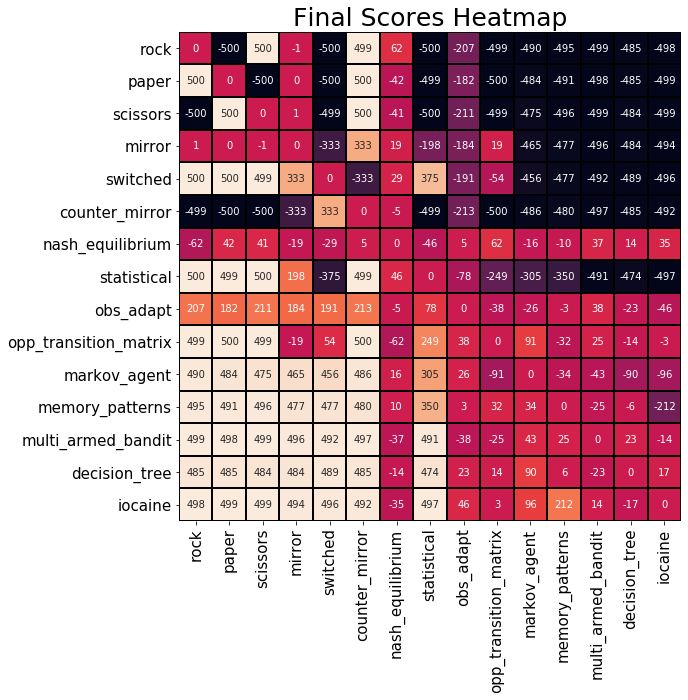

In [11]:
df_scores = pd.DataFrame(
    scores, 
    index=bot_names, 
    columns=bot_names,
)

plt.figure(figsize=(9, 9))
sns.heatmap( df_scores, annot=True, cbar=False, linewidths=1, linecolor='black', fmt='d')
plt.title('Final Scores Heatmap', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

# End Total Wins

In [14]:
df_scores.sum(axis=1)

rock                    -3613
paper                   -3680
scissors                -3702
mirror                  -2760
switched                 -752
counter_mirror          -5156
nash_equilibrium           59
statistical              -577
obs_adapt                1163
opp_transition_matrix    2325
markov_agent             2849
memory_patterns          3102
multi_armed_bandit       3449
decision_tree            3499
iocaine                  3794
dtype: int64

In [19]:
# average accuracy of each agent

for i in range(len(bot_names)):
    print(df_scores.sum(axis=1)[i] / (500 * len(bot_names)))

-0.48173333333333335
-0.49066666666666664
-0.4936
-0.368
-0.10026666666666667
-0.6874666666666667
0.007866666666666666
-0.07693333333333334
0.15506666666666666
0.31
0.3798666666666667
0.4136
0.45986666666666665
0.46653333333333336
0.5058666666666667


# Comparing Two  Agents

In [42]:
scores = np.zeros((len(bot_names), 1), dtype=int)

In [43]:
for i in range(len(bot_names)):

    current_score = evaluate(
        "rps", 
        ["iocaine.py", list_agents[i]], 
        configuration={"episodeSteps": 1000}
    )

    scores[i, 0] = current_score[0][0]

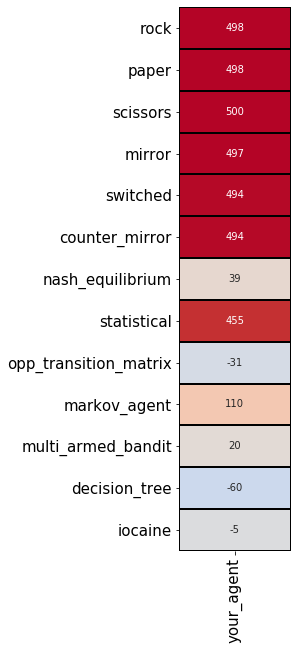

In [45]:
df_scores = pd.DataFrame(
    scores, 
    index=bot_names, 
    columns=["your_agent"],
)


plt.figure(figsize=(2, 10))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, linecolor="black", 
    fmt="d", vmin=-500, vmax=500,
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=360, fontsize=15);

# TO DO:

add:
* greenberg + fix bug
* Phasenbott - dan egnor
* MegaHAL - markov
* Dan beal's models

improve multiarmed bandit

EDA on current models on the leaderboard

tendency towards paper?

past competitions:

https://webdocs.cs.ualberta.ca/~darse/rsbpc.html

https://webdocs.cs.ualberta.ca/~darse/rsb-ts1.c